In [2]:
import numpy as np 
import pandas as pd 
import re
import json

import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!pip install emoji --upgrade
import emoji

!pip install tweet-preprocessor
import preprocessor as p

!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Adding AWS Data Wrangler
import awswrangler as wr

In [3]:
raw_s3_bucket = 'jessehernandez70test1'
raw_path_dir = 'aug_Ukraine_War/'

raw_path = f"s3://{raw_s3_bucket}/{raw_path_dir}"

aug_df = wr.s3.read_csv(path=raw_path,path_suffix=[".csv"],low_memory=False)


/Users/jessehernandez/opt/anaconda3/envs/mlenv/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  result = self.fn(*self.args, **self.kwargs)
/Users/jessehernandez/opt/anaconda3/envs/mlenv/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  result = self.fn(*self.args, **self.kwargs)


In [4]:
# show the first 5 rows of the august dataframe
aug_df.head()

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,0,369869874,ORFMumbai,"Non–partisan, independent analyses on security...","Nariman Point, Mumbai, India",51,3362,71331,2011-09-08 02:34:54.000000,1553893270027063297,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 02:30:13.601013
1,1,882984605028102144,For2000years,"""I have certain rules I live by. My first rule...",Facing East,2964,4669,119795,2017-07-06 15:28:29.000000,1553893270983409670,...,56575418,timand2037,0,0,NaN,False,0,0,NaN,2022-08-01 02:30:13.573250
2,2,862842887565869056,CumanaCandanga,IG: @CumanaCandanga\nEn #Cumaná también somos ...,"Cumana, Venezuela",6033,6730,18870,2017-05-12 01:32:30.000000,1553893271671382024,...,1441312629155237888,ProfeJesusDavid,0,0,NaN,False,0,0,NaN,2022-08-01 00:29:56.081894
3,3,1366546460557385729,EnfoquesEnCorto,📻Sigue nuestros cortes informativos 🎙Escúchano...,"Mexico, ME",195,192,20780,2021-03-02 00:30:59.000000,1553893273751666691,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 10:29:39.709724
4,4,1378766002792583168,kaotiskhund,NaN,NaN,49,8,112,2021-04-04 17:47:00.000000,1553893274687094785,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 06:59:10.496078


In [5]:
# get shape of the DataFrame
print(f"{aug_df.shape[0]} rows and {aug_df.shape[1]} columns")

1849926 rows and 29 columns


In [6]:
# Check data types
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849926 entries, 0 to 1849925
Data columns (total 29 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   Unnamed: 0               int64 
 1   userid                   int64 
 2   username                 object
 3   acctdesc                 object
 4   location                 object
 5   following                int64 
 6   followers                int64 
 7   totaltweets              int64 
 8   usercreatedts            object
 9   tweetid                  int64 
 10  tweetcreatedts           object
 11  retweetcount             int64 
 12  text                     object
 13  hashtags                 object
 14  language                 object
 15  coordinates              object
 16  favorite_count           int64 
 17  is_retweet               bool  
 18  original_tweet_id        int64 
 19  original_tweet_userid    int64 
 20  original_tweet_username  object
 21  in_reply_to_status_id    int64 

In [7]:
# Change the dtypes of usercreatedts, tweetcreatedts, and extractedts to datetime64 for easier operation later
aug_df["usercreatedts"] = pd.to_datetime(aug_df["usercreatedts"])
aug_df["tweetcreatedts"] = pd.to_datetime(aug_df["tweetcreatedts"])
aug_df["extractedts"] = pd.to_datetime(aug_df["extractedts"])

# check dtypes
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849926 entries, 0 to 1849925
Data columns (total 29 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Unnamed: 0               int64         
 1   userid                   int64         
 2   username                 object        
 3   acctdesc                 object        
 4   location                 object        
 5   following                int64         
 6   followers                int64         
 7   totaltweets              int64         
 8   usercreatedts            datetime64[ns]
 9   tweetid                  int64         
 10  tweetcreatedts           datetime64[ns]
 11  retweetcount             int64         
 12  text                     object        
 13  hashtags                 object        
 14  language                 object        
 15  coordinates              object        
 16  favorite_count           int64         
 17  is_retweet               bo

In [8]:
# When were the earliest and latest tweets in this dataset created
earliest_tweet = aug_df["tweetcreatedts"].min()
latest_tweet = aug_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

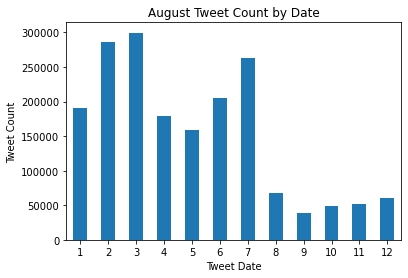

In [9]:
# Visualize tweet frequency by date
# get dates in the dataframe 
dates = aug_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = aug_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("August Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=0)
plt.show()

In [10]:
# How many languages are in this dataset
print(f"There are {aug_df['language'].nunique()} unique languages in this DataFrame.")
aug_df["language"].unique()

There are 66 unique languages in this DataFrame.


array(['en', 'es', 'zh', 'fr', 'el', 'pl', 'und', 'de', 'it', 'ja', 'nl',
       'ru', 'lv', 'ar', 'uk', 'tr', 'in', 'sr', 'sl', 'ro', 'th', 'fi',
       'pt', 'tl', 'ca', 'da', 'sv', 'ht', 'fa', 'et', 'ta', 'lt', 'hi',
       'iw', 'bn', 'ur', 'vi', 'is', 'cs', 'ko', 'kn', 'te', 'eu', 'no',
       'gu', 'ka', 'my', 'ps', 'bg', 'mr', 'hu', 'am', 'ml', 'cy', 'pa',
       'ckb', 'ne', 'si', 'hy', 'or', 'lo', 'bo', 'sd', 'km', 'ug', 'dv'],
      dtype=object)

In [11]:
# What percentage of the tweets is in English (en)
print(f"{round(aug_df.loc[aug_df['language']=='en'].shape[0]/aug_df.shape[0]*100, 2)}% of the tweets are in English.")

In [ ]:
# Plot the distribution of different languages
language_counts = aug_df.groupby("language").size().sort_values(ascending=False)[0:20].plot.bar(figsize=(12,6),
                                                                                         title="Top 20 Languages by Frequency",
                                                                                         xlabel="Language Code",
                                                                                         ylabel="Number of Tweets",
                                                                                         rot=90
                                                                                         );

plt.xticks(rotation=0)
plt.show()

We can see that English (en) was by far the most prevalent language in this dataset, nearing 1.2 million tweets out of 1.96 million. The second and third most prevalent languages were French and Thai, respectively.

Note that the forth most prevalent language was "und", which is used to indicate that Twitter could not detect a language. We can safely inspect English language only.

In [12]:
# Inspect shortest and longest tweets
min_len = aug_df["text"].str.len().min()
max_len = aug_df["text"].str.len().max()


print(f"Shortest tweet has {min_len} chars.")
print(f"Longest tweet has {max_len} chars.")

Hold on, a tweet can have 280 characters max. How could one have more than the limit?

In [13]:
# get index of the tweet that has the max length
max_len_index = aug_df["text"].str.len().idxmax()
# pull out the text of that index
aug_df.loc[max_len_index, "text"]

'@HashmatRuhul @mosad42027539 @SinghRakeshKu14 @MdtajKohri5 @RajaRajavira @SavitaSikarwar @Hisamud47588796 @indianposten @Ahimsa1616 @SudhirDevSharma @_Mahakal_D_ @JitendraManoha6 @0ff1ddfa2afa4f0 @55659754Bhaskar @ADiravia @MuzaffarIslam11 @RomitSoniya @Rao26641901Gs @Chandra51364237 @RajivSi45818862 @SharrmaPoonam @MdIqbal64955168 @RajeshS50119232 @Pandey13K @VinodKu51806624 @aj23004007 @SanjayP46456817 @VineetPubby @Shakeelsayed14 @RajeshK83114811 @Saudager5 @AnilKum04619533 @Azad_Parinda1 @Ramesh270549 @Om44857240 @nareshsharma107 @1000dineshshar1 @ra_hindustani @Monaji58641983 @ajswal1a @Swarnim52450008 @saifi_111 @smilewithbuddha @lari_shakil @UmmedRawna @KoliThakorSamaj @INCIndia @SoniyaGandhiIND @RahulGandhi @narendramodi O Allah, Gaza, its people &amp; its Mujahideen\nIn Your protection &amp; comfort\nO Allah, support them with Your soldiers &amp; turn away from them the plot of Your enemy\nO Allah, guard them with Your eyes that do not sleep\n#فريق_مجاهدون\n#GazaUnderAttack\n

Upon research, mentions supposedly do not count toward the character limit when the tweet is a reply.

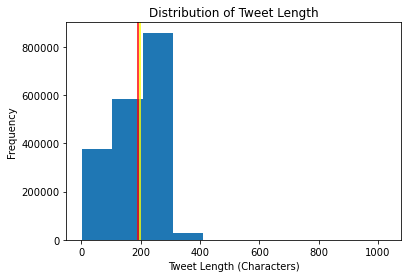

Mean: 192.2334158231194 chars
Median: 199.0 chars
Standard deviation: 86.09440832234304 chars


In [14]:
# Check the distribution of tweet lengths
tweet_len_series = aug_df["text"].str.len()
tweet_len_series.plot.hist();
plt.title("Distribution of Tweet Length")
plt.xlabel("Tweet Length (Characters)")
plt.ylabel("Frequency")
# draw a vertical line for the mean
plt.axvline(x=tweet_len_series.mean(), color="red")
# draw a vertical line for the median
plt.axvline(x=tweet_len_series.median(), color="yellow")
plt.show()

print(f"Mean: {tweet_len_series.mean()} chars")
print(f"Median: {tweet_len_series.median()} chars")
print(f"Standard deviation: {tweet_len_series.std()} chars")

The distribution is right-skewed. Most tweets appear to be below 300 characers in length. But because we have a few outlying tweets that have anomalously long lengths, as investigated above, the histogram has an elongated x-axis

## Data Cleaning

In [15]:
# Drop the non-English tweets
eng_df=aug_df.loc[aug_df['language']=='en']
eng_df.head()

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,0,369869874,ORFMumbai,"Non–partisan, independent analyses on security...","Nariman Point, Mumbai, India",51,3362,71331,2011-09-08 02:34:54,1553893270027063297,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 02:30:13.601013
1,1,882984605028102144,For2000years,"""I have certain rules I live by. My first rule...",Facing East,2964,4669,119795,2017-07-06 15:28:29,1553893270983409670,...,56575418,timand2037,0,0,NaN,False,0,0,NaN,2022-08-01 02:30:13.573250
4,4,1378766002792583168,kaotiskhund,NaN,NaN,49,8,112,2021-04-04 17:47:00,1553893274687094785,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 06:59:10.496078
5,5,180748385,orfonline,"Non–partisan, independent analyses on security...",India,137,114789,315096,2010-08-20 11:19:22,1553893275081158656,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 01:44:58.884242
6,6,817314182055993344,orfecon,Centre for Economy and Growth @orfonline.,India,27,3059,13665,2017-01-06 10:17:40,1553893276079382528,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 05:13:47.957650


In [16]:
# Drop the tweets longer then 280 symbols
short_df = eng_df.loc[eng_df["text"].str.len() < 280]

short_df.head()

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,0,369869874,ORFMumbai,"Non–partisan, independent analyses on security...","Nariman Point, Mumbai, India",51,3362,71331,2011-09-08 02:34:54,1553893270027063297,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 02:30:13.601013
1,1,882984605028102144,For2000years,"""I have certain rules I live by. My first rule...",Facing East,2964,4669,119795,2017-07-06 15:28:29,1553893270983409670,...,56575418,timand2037,0,0,NaN,False,0,0,NaN,2022-08-01 02:30:13.573250
4,4,1378766002792583168,kaotiskhund,NaN,NaN,49,8,112,2021-04-04 17:47:00,1553893274687094785,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 06:59:10.496078
5,5,180748385,orfonline,"Non–partisan, independent analyses on security...",India,137,114789,315096,2010-08-20 11:19:22,1553893275081158656,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 01:44:58.884242
6,6,817314182055993344,orfecon,Centre for Economy and Growth @orfonline.,India,27,3059,13665,2017-01-06 10:17:40,1553893276079382528,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-08-01 05:13:47.957650


In [ ]:
# Check which columns have missing values
short_df.isna().any()

Have missing values following columns: 
* acctdesc (account description), 
* location, 
* coordinates, 
* original_tweet_username, 
* in_reply_to_screen_name,
* quoted_status_username 

acctdesc, original_tweet_username, in_reply_to_screen_name, quoted_status_username  columns contain information, we are not concerned at with this moment. For now, we will rely on the tweets to learn more about what kind of words are frequently used and the users' sentiments surrounding the war in Ukraine. Therefore, we will drop acctdesc column.

In [17]:
# Drop the not important columns
short_df.drop("acctdesc", axis=1, inplace=True)
# short_df.drop("original_tweet_username", axis=1, inplace=True)
# short_df.drop("in_reply_to_screen_name", axis=1, inplace=True)
# short_df.drop("quoted_status_username", axis=1, inplace=True)
# confirm it has been dropped
short_df.info()

/Users/jessehernandez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 814834 entries, 0 to 1849925
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Unnamed: 0               814834 non-null  int64         
 1   userid                   814834 non-null  int64         
 2   username                 814834 non-null  object        
 3   location                 481566 non-null  object        
 4   following                814834 non-null  int64         
 5   followers                814834 non-null  int64         
 6   totaltweets              814834 non-null  int64         
 7   usercreatedts            814834 non-null  datetime64[ns]
 8   tweetid                  814834 non-null  int64         
 9   tweetcreatedts           814834 non-null  datetime64[ns]
 10  retweetcount             814834 non-null  int64         
 11  text                     814834 non-null  object        
 12  hashtags       

In [ ]:
import aswrangler as wr

In [ ]:
raw_s3_bucket = 'aiscience22'
raw_path_dir = 'aug_Ukraine_War/'

raw_path = f"s3://{raw_s3_bucket}/{raw_path_dir}

aug_df = wr.s3.read_csv(path=raw_path)

aug_df.head()